# Chess Agents Performance Analysis
This notebook analyzes chess performance data from different agents based on Stockfish analysis.

In [1]:
# Import necessary libraries
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Set better visualization defaults
plt.style.use('fivethirtyeight')
plt.rcParams['figure.figsize'] = (14, 8)
sns.set_palette("colorblind")

## 1. Load the Data

In [2]:
# Load the Stockfish analysis results
with open('results_stockfish_old.json', 'r') as f:
    data = json.load(f)

# Display the structure of the data
print(type(data))
print(f"Number of games analyzed: {len(data)}")

# Show a sample game
if isinstance(data, list) and len(data) > 0:
    print("\nSample game data:")
    print(json.dumps(data[0], indent=2))
elif isinstance(data, dict):
    print("\nData structure:")
    for key in data.keys():
        print(f"- {key}")

<class 'list'>
Number of games analyzed: 101

Sample game data:
{
  "white": "Random AI",
  "black": "Greedy AI",
  "winner": "black",
  "outcome_reason": "checkmate",
  "metrics": {
    "white": {
      "name": "Random AI",
      "moves_count": 28,
      "total_cp_loss": 3272,
      "position_scores": [
        38,
        20,
        2,
        0,
        8,
        34,
        -14,
        -51,
        -32,
        -806,
        -785,
        -871,
        -889,
        -903,
        -799,
        -985,
        -955,
        -737,
        -1041,
        -1079,
        -1193,
        -1297,
        -1386,
        -1326,
        -1322,
        -1453,
        -1438,
        -10000
      ],
      "move_qualities": {
        "brilliant": 4,
        "excellent": 1,
        "good": 4,
        "inaccuracy": 6,
        "mistake": 5,
        "blunder": 8
      },
      "phase_performance": {
        "opening": 106.0,
        "middlegame": 125.0,
        "endgame": 0
      },
      "mate_seque

## 2. Transform Data into a Structured DataFrame

In [3]:
def extract_game_data(game_data):
    games = []
    for game_id, game in enumerate(game_data):
        # Get result info
        winner = game.get("winner", "Unknown")
        outcome_reason = game.get("outcome_reason", "Unknown")
        
        # Extract white player's metrics and agent name
        if "white" in game and "metrics" in game and "white" in game["metrics"]:
            white_data = game["metrics"]["white"]
            white_agent = game["white"]  # agent name is stored here
            
            # Get position scores (if available)
            position_scores = white_data.get('position_scores', [])
            final_score = position_scores[-1] if position_scores else None
            
            games.append({
                'game_id': game_id,
                'agent': white_agent,
                'color': 'white',
                'moves_count': white_data.get('moves_count', 0),
                'total_cp_loss': white_data.get('total_cp_loss', 0),
                'acpl': white_data.get('acpl', 0),
                # Use safer nested gets for potentially missing fields
                'brilliant': white_data.get('move_qualities', {}).get('brilliant', 0),
                'excellent': white_data.get('move_qualities', {}).get('excellent', 0),
                'good': white_data.get('move_qualities', {}).get('good', 0),
                'inaccuracy': white_data.get('move_qualities', {}).get('inaccuracy', 0),
                'mistake': white_data.get('move_qualities', {}).get('mistake', 0),
                'blunder': white_data.get('move_qualities', {}).get('blunder', 0),
                'position_volatility': white_data.get('position_volatility', 0),
                'decisive_move_percentage': white_data.get('decisive_move_percentage', 0),
                'opening_performance': white_data.get('phase_performance', {}).get('opening', 0),
                'middlegame_performance': white_data.get('phase_performance', {}).get('middlegame', 0),
                'endgame_performance': white_data.get('phase_performance', {}).get('endgame', 0),
                'winner': winner,
                'outcome_reason': outcome_reason,
                'is_winner': winner == 'white',
                'final_score': final_score,
                'avg_position_score': sum(position_scores) / len(position_scores) if position_scores else None
            })
        
        # Extract black player's metrics and agent name
        if "black" in game and "metrics" in game and "black" in game["metrics"]:
            black_data = game["metrics"]["black"]
            black_agent = game["black"]  # agent name is stored here
            
            # Get position scores (if available)
            position_scores = black_data.get('position_scores', [])
            final_score = position_scores[-1] if position_scores else None
            
            games.append({
                'game_id': game_id,
                'agent': black_agent,
                'color': 'black',
                'moves_count': black_data.get('moves_count', 0),
                'total_cp_loss': black_data.get('total_cp_loss', 0),
                'acpl': black_data.get('acpl', 0),
                # Use safer nested gets for potentially missing fields
                'brilliant': black_data.get('move_qualities', {}).get('brilliant', 0),
                'excellent': black_data.get('move_qualities', {}).get('excellent', 0),
                'good': black_data.get('move_qualities', {}).get('good', 0),
                'inaccuracy': black_data.get('move_qualities', {}).get('inaccuracy', 0),
                'mistake': black_data.get('move_qualities', {}).get('mistake', 0),
                'blunder': black_data.get('move_qualities', {}).get('blunder', 0),
                'position_volatility': black_data.get('position_volatility', 0),
                'decisive_move_percentage': black_data.get('decisive_move_percentage', 0),
                'opening_performance': black_data.get('phase_performance', {}).get('opening', 0),
                'middlegame_performance': black_data.get('phase_performance', {}).get('middlegame', 0),
                'endgame_performance': black_data.get('phase_performance', {}).get('endgame', 0),
                'winner': winner,
                'outcome_reason': outcome_reason,
                'is_winner': winner == 'black',
                'final_score': final_score,
                'avg_position_score': sum(position_scores) / len(position_scores) if position_scores else None
            })
    
    return pd.DataFrame(games)


# First extract all unique agent names from the data
available_agents = set()
for game in data:
    if "white" in game:
        available_agents.add(game["white"])
    if "black" in game:
        available_agents.add(game["black"])

# Print available agents for reference
print("Available agents:")
for agent in sorted(available_agents):
    print(f"- {agent}")

# Define which agents to include in the analysis
# Modify this list to filter which agents you want to analyze
selected_agents = list(available_agents)  # Default: include all agents
selected_agents = ["AlphaBetaSearchAI", "Greedy AI", "MCTS AI", "Random AI", "Score CNN2", "Stockfish AI", "Transformer AI"]
# To analyze only specific agents, modify the list, e.g.: selected_agents = ["Random AI"]

# Transform the data
try:
    # First extract all the data
    df = extract_game_data(data)
    print(f"Successfully created DataFrame with {len(df)} rows")
    
    # Then filter by selected agents if the list is not empty
    if selected_agents:
        df = df[df['agent'].isin(selected_agents)]
        print(f"Filtered to {len(df)} rows after selecting agents: {', '.join(selected_agents)}")
    
    display(df.head())
except Exception as e:
    print(f"Error creating DataFrame: {e}")
    print("Please modify the extract_game_data function based on your actual data structure")

Available agents:
- AlphaBetaSearchAI
- Greedy AI
- MCTS AI
- Random AI
- Score CNN
- Score CNN2
- ScratchFish AI
- Stockfish AI
- TD Learning AI
- Transformer AI
- Transformer Alpha-Beta Enhanced
Successfully created DataFrame with 154 rows
Filtered to 137 rows after selecting agents: AlphaBetaSearchAI, Greedy AI, MCTS AI, Random AI, Score CNN2, Stockfish AI, Transformer AI


,game_id,agent,color,moves_count,total_cp_loss,acpl,brilliant,excellent,good,inaccuracy,...,position_volatility,decisive_move_percentage,opening_performance,middlegame_performance,endgame_performance,winner,outcome_reason,is_winner,final_score,avg_position_score
0,0,Random AI,white,28,3272,116.857143,4,1,4,6,...,1803.603833,17.857143,106.000000,125.000000,0.0,black,checkmate,False,-10000,-1045.000000
1,0,Greedy AI,black,28,21883,781.535714,8,3,4,2,...,1785.962998,17.857143,25.583333,1348.500000,0.0,black,checkmate,True,10000,1162.250000
2,1,Random AI,white,50,12995,259.900000,10,2,4,14,...,347.756867,12.000000,95.677419,527.842105,0.0,black,move_limit,False,-1294,-876.960000
3,1,Greedy AI,black,50,12222,244.440000,11,2,4,17,...,1306.999791,6.000000,51.064516,559.947368,0.0,black,move_limit,True,1321,1128.840000
4,2,Random AI,white,44,21921,498.204545,7,2,3,13,...,2325.616932,13.636364,712.500000,375.750000,0.0,black,checkmate,False,-1198,-1507.522727


## 3. Agent Performance Analysis

In [4]:
# Check unique agents in the dataset
try:
    unique_agents = df['agent'].unique()
    print(f"Found {len(unique_agents)} unique agents: {', '.join(unique_agents)}")

    # Create a summary DataFrame grouped by agent
    agent_summary = df.groupby('agent').agg({
        'game_id': 'nunique',  # Number of games played
        'acpl': 'mean',        # Average centipawn loss
        'total_cp_loss': 'mean',
        'brilliant': 'sum',
        'excellent': 'sum',
        'good': 'sum',
        'inaccuracy': 'sum',
        'mistake': 'sum',
        'blunder': 'sum',
        'position_volatility': 'mean',
        'decisive_move_percentage': 'mean',
        'opening_performance': 'mean',
        'middlegame_performance': 'mean',
        'endgame_performance': 'mean'
    })
    
    # Rename columns for clarity
    agent_summary.rename(columns={
        'game_id': 'Games Played',
        'acpl': 'Avg Centipawn Loss',
        'total_cp_loss': 'Avg Total CP Loss',
        'position_volatility': 'Avg Position Volatility',
        'decisive_move_percentage': 'Avg Decisive Move %',
        'opening_performance': 'Opening Performance',
        'middlegame_performance': 'Middlegame Performance',
        'endgame_performance': 'Endgame Performance'
    }, inplace=True)
    
    # Display the summary
    display(agent_summary)
except Exception as e:
    print(f"Error in agent performance analysis: {e}")

Found 7 unique agents: Random AI, Greedy AI, Transformer AI, MCTS AI, Stockfish AI, AlphaBetaSearchAI, Score CNN2


,Games Played,Avg Centipawn Loss,Avg Total CP Loss,brilliant,excellent,good,inaccuracy,mistake,blunder,Avg Position Volatility,Avg Decisive Move %,Opening Performance,Middlegame Performance,Endgame Performance
agent,,,,,,,,,,,,,,
AlphaBetaSearchAI,7,1923.162626,30912.142857,46,9,11,25,23,28,3528.868297,16.724387,781.624833,3935.352381,0.000000
Greedy AI,27,1114.434479,31400.259259,175,43,69,168,162,209,2477.793414,19.679175,276.623857,2256.136812,4.740741
MCTS AI,10,1013.665339,21876.600000,47,5,9,43,45,108,2374.402642,34.062826,468.136774,1605.396071,0.000000
Random AI,57,909.749616,31386.368421,289,57,115,322,348,901,1816.286216,34.167782,412.981051,1197.693538,0.000000
Score CNN2,7,831.224396,33907.857143,18,3,13,32,48,212,483.436994,56.681319,946.689869,275.686797,0.000000
Stockfish AI,10,1554.871281,20277.200000,90,21,13,25,8,11,2763.470556,8.370049,931.813218,1520.145711,0.000000
Transformer AI,19,1827.444887,74773.842105,224,42,52,100,76,243,3486.115296,29.349475,219.779950,2469.605101,358.487469


## 4. Visualizing Key Performance Metrics

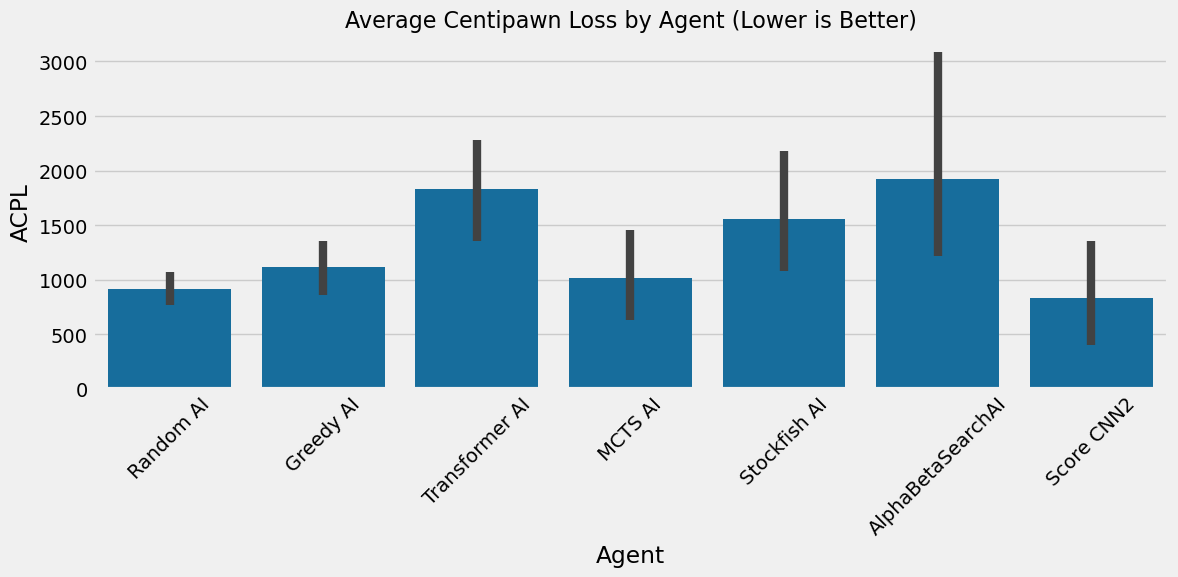

In [5]:
# ACPL Comparison
plt.figure(figsize=(12, 6))
try:
    sns.barplot(x='agent', y='acpl', data=df)
    plt.title('Average Centipawn Loss by Agent (Lower is Better)', fontsize=16)
    plt.ylabel('ACPL')
    plt.xlabel('Agent')
    plt.xticks(rotation=45)
    plt.grid(True, axis='y')
    plt.tight_layout()
    plt.show()
except Exception as e:
    print(f"Error plotting ACPL: {e}")

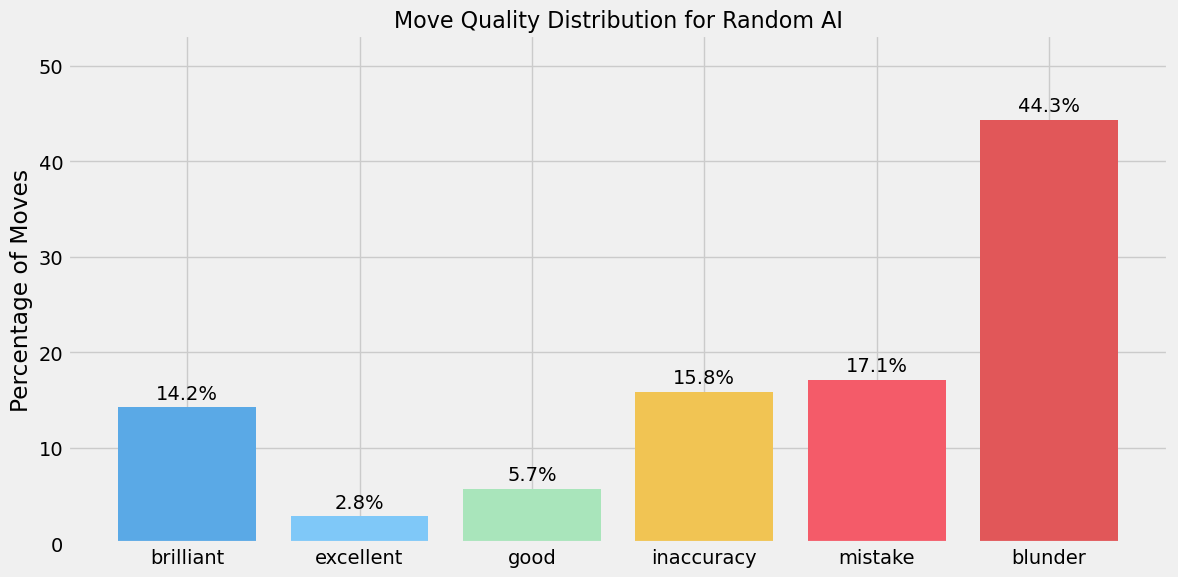

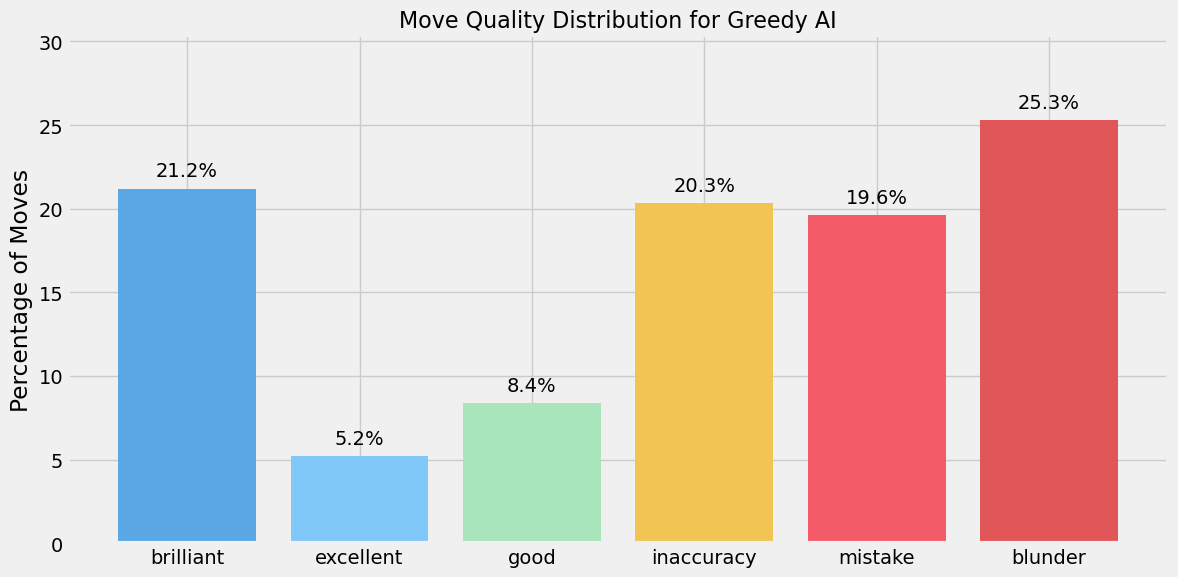

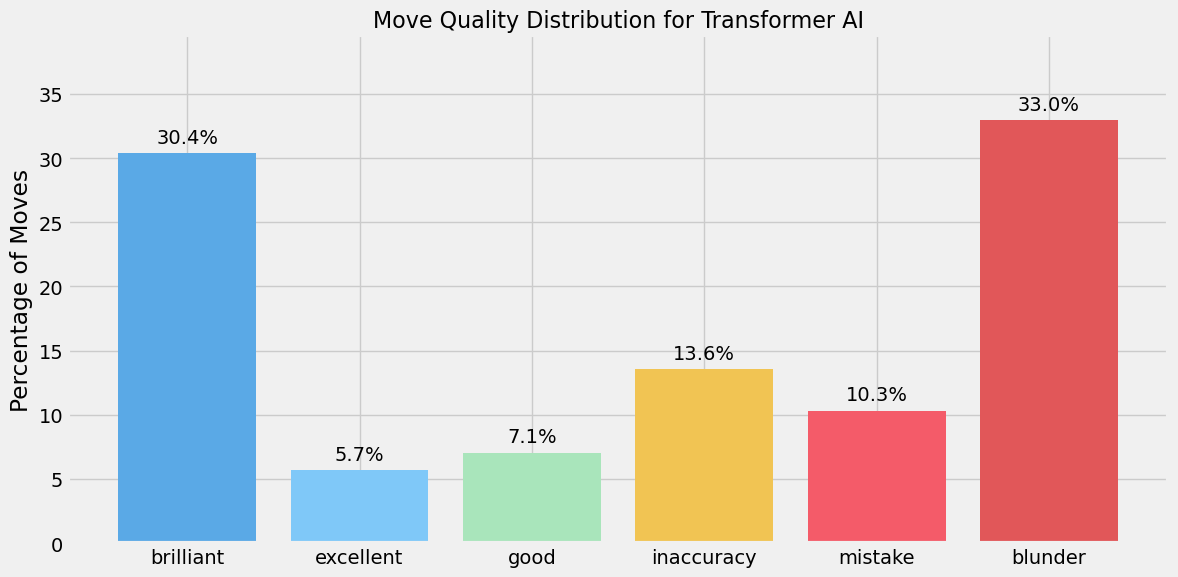

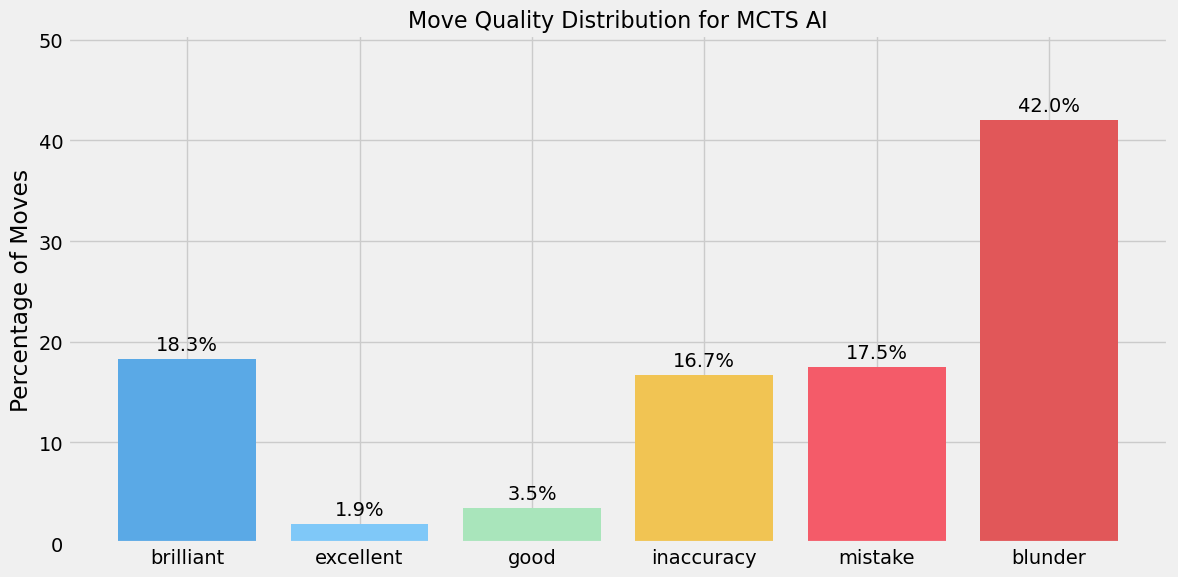

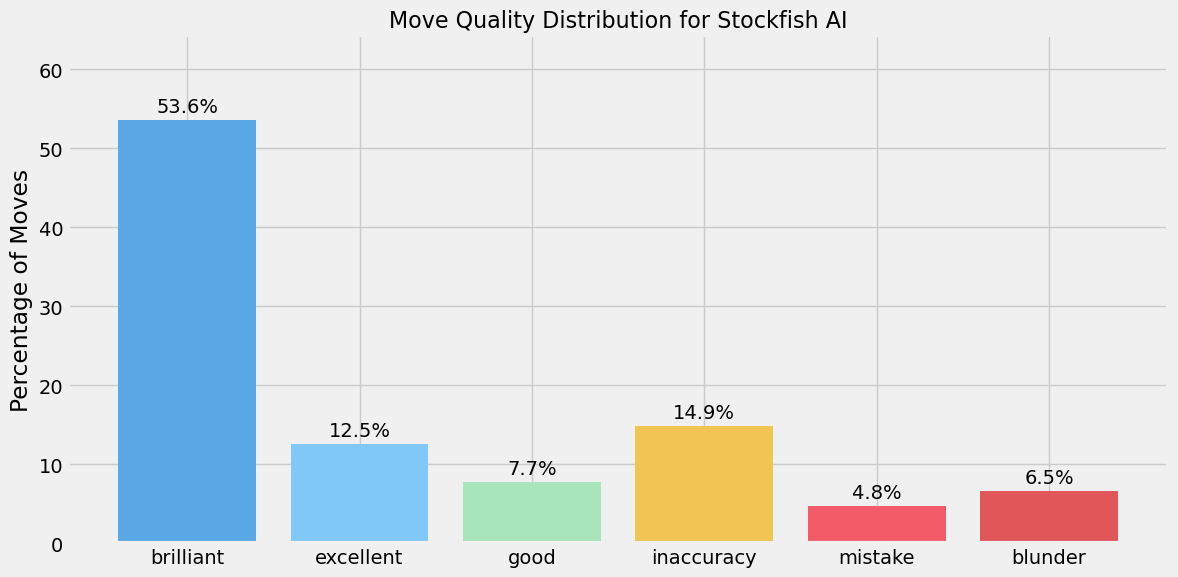

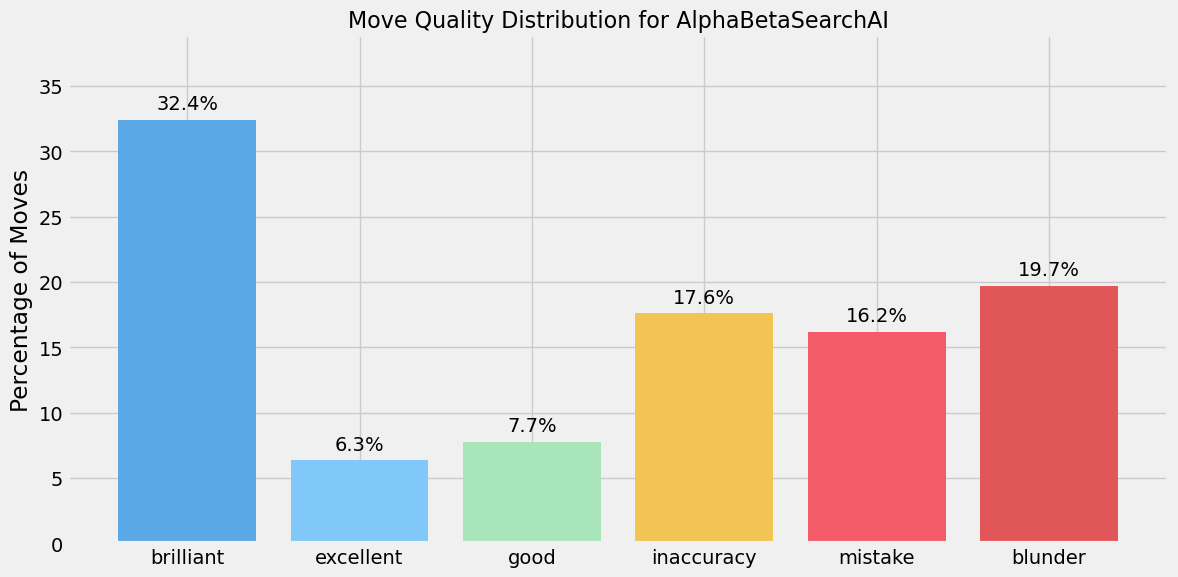

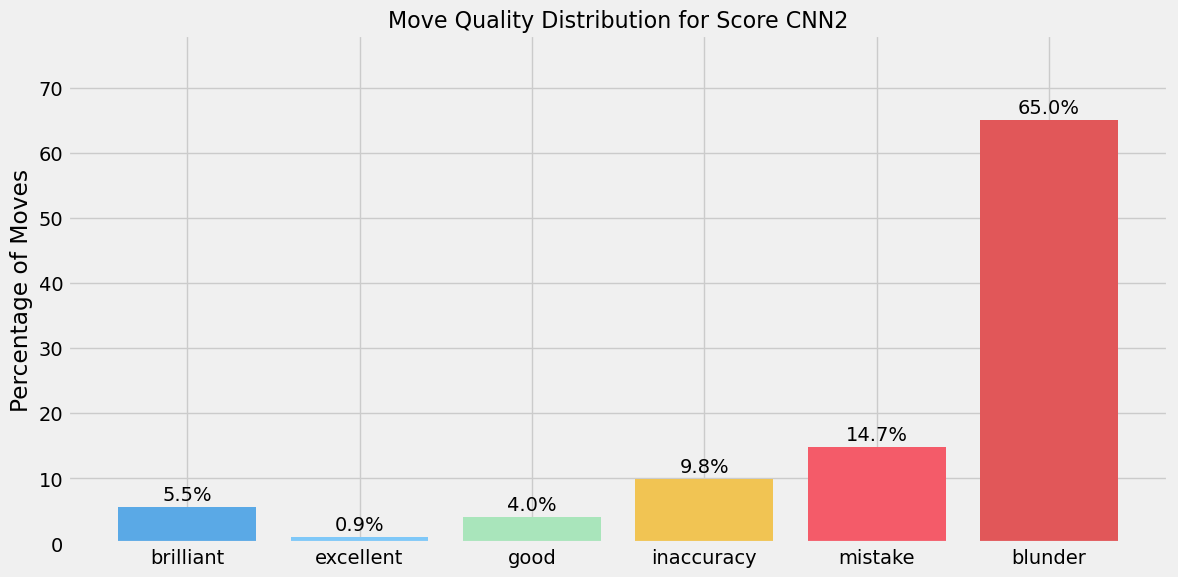

In [6]:
# Move Quality Distribution
try:
    # Calculate total moves for each agent
    for agent in unique_agents:
        agent_df = df[df['agent'] == agent]
        total_qualified_moves = agent_df[['brilliant', 'excellent', 'good', 'inaccuracy', 'mistake', 'blunder']].sum().sum()
        
        # Create move quality distribution
        move_qualities = ['brilliant', 'excellent', 'good', 'inaccuracy', 'mistake', 'blunder']
        qualities_count = [agent_df[quality].sum() for quality in move_qualities]
        qualities_pct = [count/total_qualified_moves*100 if total_qualified_moves > 0 else 0 for count in qualities_count]
        
        # Plot
        plt.figure(figsize=(12, 6))
        bars = plt.bar(move_qualities, qualities_pct, color=['#5AA9E6', '#7FC8F8', '#A9E5BB', '#F1C453', '#F45B69', '#E15759'])
        
        # Add value labels
        for bar in bars:
            height = bar.get_height()
            plt.text(bar.get_x() + bar.get_width()/2., height + 0.5,
                    f'{height:.1f}%', ha='center', va='bottom')
            
        plt.title(f'Move Quality Distribution for {agent}', fontsize=16)
        plt.ylabel('Percentage of Moves')
        plt.ylim(0, max(qualities_pct) * 1.2 if max(qualities_pct) > 0 else 10)  # Add some headroom
        plt.grid(True, axis='y')
        plt.tight_layout()
        plt.show()
except Exception as e:
    print(f"Error plotting move quality distribution: {e}")

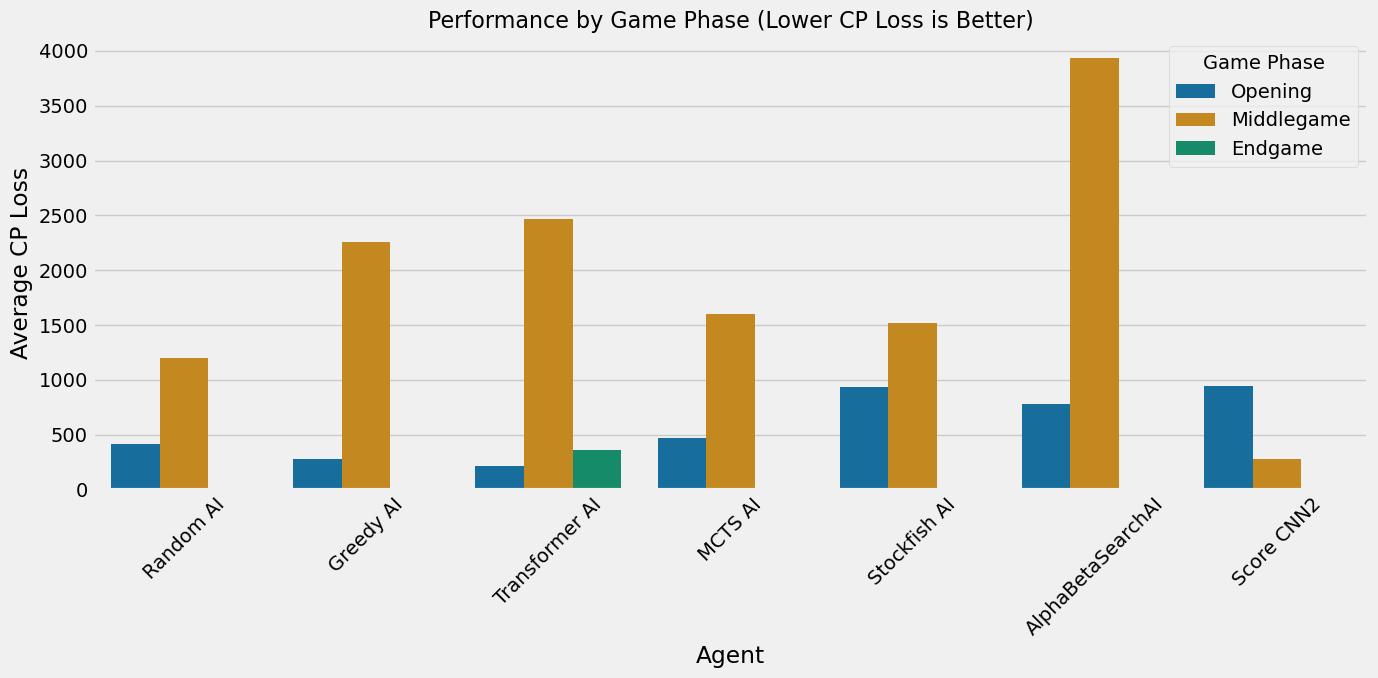

In [7]:
# Phase Performance Comparison
try:
    # Prepare data for visualization
    phase_data = []
    for agent in unique_agents:
        agent_df = df[df['agent'] == agent]
        # Get average performance for each phase
        opening = agent_df['opening_performance'].mean()
        middlegame = agent_df['middlegame_performance'].mean()
        endgame = agent_df['endgame_performance'].mean()
        
        # Add to data collection
        phase_data.append({'Agent': agent, 'Phase': 'Opening', 'CP Loss': opening})
        phase_data.append({'Agent': agent, 'Phase': 'Middlegame', 'CP Loss': middlegame})
        phase_data.append({'Agent': agent, 'Phase': 'Endgame', 'CP Loss': endgame})
    
    # Create DataFrame and visualize
    phase_df = pd.DataFrame(phase_data)
    
    plt.figure(figsize=(14, 7))
    sns.barplot(x='Agent', y='CP Loss', hue='Phase', data=phase_df)
    plt.title('Performance by Game Phase (Lower CP Loss is Better)', fontsize=16)
    plt.ylabel('Average CP Loss')
    plt.xticks(rotation=45)
    plt.grid(True, axis='y')
    plt.legend(title='Game Phase')
    plt.tight_layout()
    plt.show()
except Exception as e:
    print(f"Error plotting phase performance: {e}")

## 5. Game Results Analysis

game_result,Draw,Loss,Win,Unknown,Total Games,Win %,Draw %,Loss %
agent,,,,,,,,
AlphaBetaSearchAI,0,0,7,0,7,100.000000,0.000000,0.000000
Greedy AI,1,3,23,0,27,85.185185,3.703704,11.111111
MCTS AI,0,8,2,0,10,20.000000,0.000000,80.000000
Random AI,6,39,12,0,57,21.052632,10.526316,68.421053
Score CNN2,0,3,4,0,7,57.142857,0.000000,42.857143
Stockfish AI,0,0,10,0,10,100.000000,0.000000,0.000000
Transformer AI,7,3,9,0,19,47.368421,36.842105,15.789474


outcome_reason,checkmate,move_limit,repetition,stalemate
agent,,,,
AlphaBetaSearchAI,7,0,0,0
Greedy AI,22,4,1,0
MCTS AI,8,2,0,0
Random AI,33,20,0,4
Score CNN2,1,6,0,0
Stockfish AI,10,0,0,0
Transformer AI,7,7,1,4


<Figure size 1400x700 with 0 Axes>

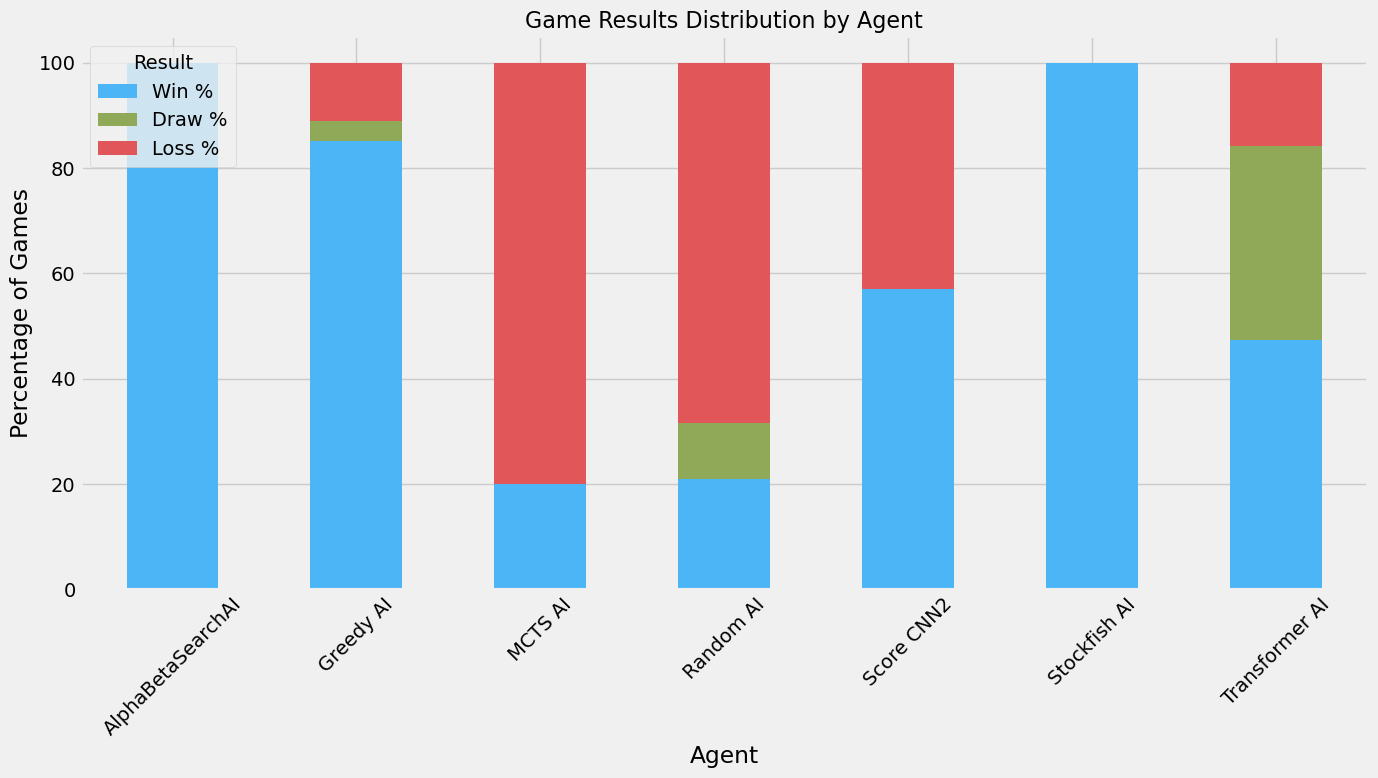

<Figure size 1400x700 with 0 Axes>

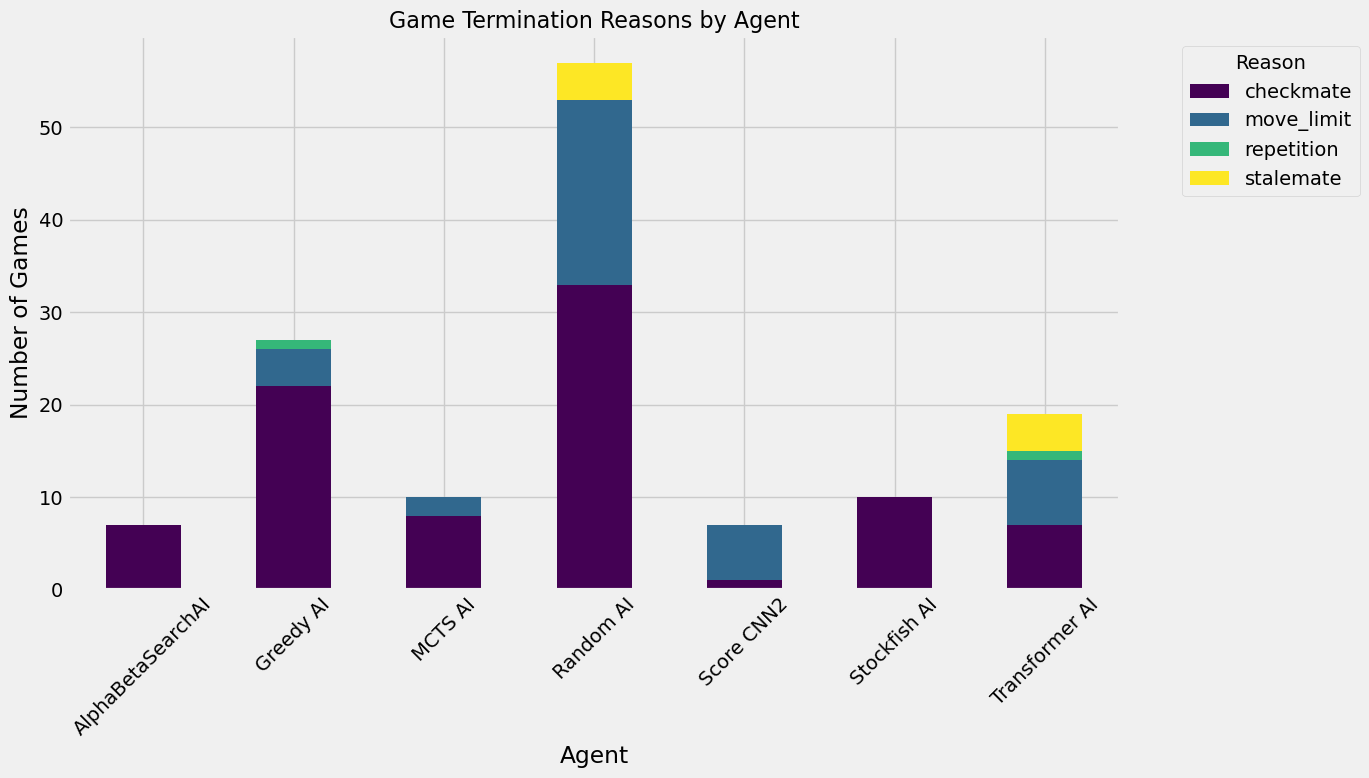

In [8]:
# Win/Loss/Draw Analysis by Agent with Explicit Results
try:
    df.reset_index(drop=True, inplace=True)
    
    # Function to determine the result directly from winner information
    def determine_result(row):
        # If this player's color matches the winner, it's a win
        if row['color'] == row['winner']:
            return 'Win'
        # If the other color won, it's a loss
        elif row['winner'] in ['white', 'black'] and row['color'] != row['winner']:
            return 'Loss'
        # If winner is 'draw', it's a draw
        elif row['winner'] == 'draw':
            return 'Draw'
        # Handle unknown situations
        else:
            return 'Unknown'
    
    # Create a new column with the game outcome for each side
    df['game_result'] = df.apply(determine_result, axis=1)
    
    # Count results by agent
    result_counts = df.groupby(['agent', 'game_result']).size().unstack(fill_value=0)
    
    # Ensure the expected columns exist
    for col in ['Win', 'Loss', 'Draw', 'Unknown']:
        if col not in result_counts.columns:
            result_counts[col] = 0

    # Calculate percentages
    result_counts['Total Games'] = result_counts.sum(axis=1)
    result_counts['Win %'] = result_counts['Win'] / result_counts['Total Games'] * 100
    
    # Only include Draw % if there are draws
    if 'Draw' in result_counts.columns:
        result_counts['Draw %'] = result_counts['Draw'] / result_counts['Total Games'] * 100
    else:
        result_counts['Draw %'] = 0
        
    result_counts['Loss %'] = result_counts['Loss'] / result_counts['Total Games'] * 100

    display(result_counts)
    
    # Add outcome reason analysis
    outcome_counts = df.groupby(['agent', 'outcome_reason']).size().unstack(fill_value=0)
    display(outcome_counts)
    
    # Plot win/loss/draw distribution by agent
    plt.figure(figsize=(14, 7))
    result_columns = [col for col in ['Win %', 'Draw %', 'Loss %'] if col in result_counts.columns]
    result_counts[result_columns].plot(kind='bar', stacked=True, 
                                       color=['#4CB5F5', '#90A959', '#E15759'])
    plt.title('Game Results Distribution by Agent', fontsize=16)
    plt.ylabel('Percentage of Games')
    plt.xlabel('Agent')
    plt.xticks(rotation=45)
    plt.grid(True, axis='y')
    plt.legend(title='Result')
    plt.tight_layout()
    plt.show()
    
    # Bonus: Plot outcome reasons by agent
    plt.figure(figsize=(14, 7))
    outcome_counts.plot(kind='bar', stacked=True, colormap='viridis')
    plt.title('Game Termination Reasons by Agent', fontsize=16)
    plt.ylabel('Number of Games')
    plt.xlabel('Agent')
    plt.xticks(rotation=45)
    plt.grid(True, axis='y')
    plt.legend(title='Reason', bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()
    plt.show()
    
except Exception as e:
    print(f"Error in game results analysis: {e}")
    import traceback
    traceback.print_exc()

## 6. ELO Rating Estimation

,Agent,Elo Rating
0,Greedy AI,1130
1,Stockfish AI,1107
2,AlphaBetaSearchAI,1057
3,Transformer AI,1017
4,Score CNN2,963
5,MCTS AI,923
6,Random AI,798


,agent,games_played,games_won,win_rate
0,AlphaBetaSearchAI,7,7,1.000000
1,Stockfish AI,10,10,1.000000
2,Greedy AI,27,23,0.851852
3,Score CNN2,7,4,0.571429
4,Transformer AI,19,9,0.473684
5,Random AI,57,12,0.210526
6,MCTS AI,10,2,0.200000


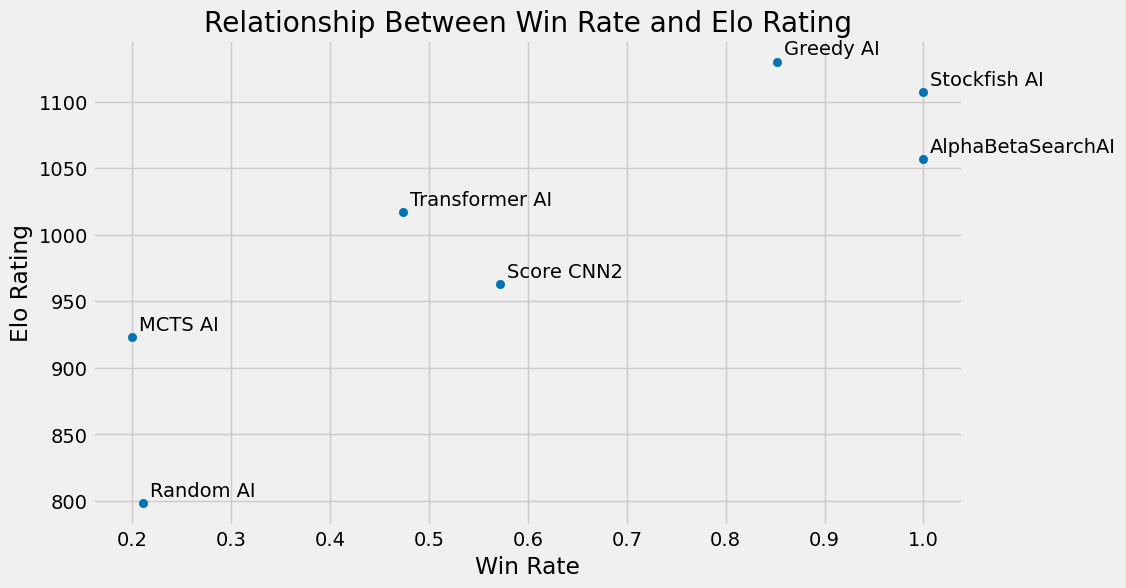

In [9]:
def calculate_elo_ratings(df, initial_elo=1000, k_factor=32):
    """
    Calculate Elo ratings for chess agents based on their game results.
    
    Parameters:
    - df: DataFrame containing game results
    - initial_elo: Starting Elo for all agents (default 1000)
    - k_factor: How quickly ratings change (default 32)
    
    Returns:
    - Dictionary of agent names and their Elo ratings
    """
    # Get unique agents
    agents = df['agent'].unique()
    
    # Initialize Elo ratings
    elo_ratings = {agent: initial_elo for agent in agents}
    
    # Group games by game_id to process each game once
    game_ids = df['game_id'].unique()
    
    for game_id in game_ids:
        game_df = df[df['game_id'] == game_id]
        
        # Skip games with incomplete data
        if len(game_df) != 2:
            continue
            
        # Get player data
        white_player = game_df[game_df['color'] == 'white'].iloc[0]
        black_player = game_df[game_df['color'] == 'black'].iloc[0]
        
        white_agent = white_player['agent']
        black_agent = black_player['agent']
        
        # Get current ratings
        white_rating = elo_ratings[white_agent]
        black_rating = elo_ratings[black_agent]
        
        # Expected scores (probability of winning)
        expected_white = 1 / (1 + 10 ** ((black_rating - white_rating) / 400))
        expected_black = 1 - expected_white
        
        # Actual scores
        if white_player['is_winner']:
            actual_white = 1
            actual_black = 0
        elif black_player['is_winner']:
            actual_white = 0
            actual_black = 1
        else:
            # Draw case
            actual_white = 0.5
            actual_black = 0.5
        
        # Update ratings
        elo_ratings[white_agent] += k_factor * (actual_white - expected_white)
        elo_ratings[black_agent] += k_factor * (actual_black - expected_black)
    
    # Convert to integers for readability
    elo_ratings = {agent: int(rating) for agent, rating in elo_ratings.items()}
    
    return elo_ratings

# Calculate Elo ratings
elo_ratings = calculate_elo_ratings(df)

# Create a DataFrame to display the results
elo_df = pd.DataFrame({
    'Agent': list(elo_ratings.keys()),
    'Elo Rating': list(elo_ratings.values())
}).sort_values(by='Elo Rating', ascending=False).reset_index(drop=True)

# Display Elo ratings
display(elo_df)

# Calculate and display win rates for comparison
win_rate_df = df.groupby('agent').agg(
    games_played=('game_id', 'count'),
    games_won=('is_winner', 'sum')
).reset_index()

win_rate_df['win_rate'] = win_rate_df['games_won'] / win_rate_df['games_played']
win_rate_df = win_rate_df.sort_values(by='win_rate', ascending=False).reset_index(drop=True)

display(win_rate_df)

# Validate the relationship between Elo and win rates
plt.figure(figsize=(10, 6))
plt.scatter(win_rate_df['win_rate'], [elo_ratings[agent] for agent in win_rate_df['agent']])
for i, agent in enumerate(win_rate_df['agent']):
    plt.annotate(agent, 
                 (win_rate_df['win_rate'].iloc[i], elo_ratings[agent]),
                 textcoords='offset points',
                 xytext=(5, 5))
plt.xlabel('Win Rate')
plt.ylabel('Elo Rating')
plt.title('Relationship Between Win Rate and Elo Rating')
plt.grid(True)
plt.show()

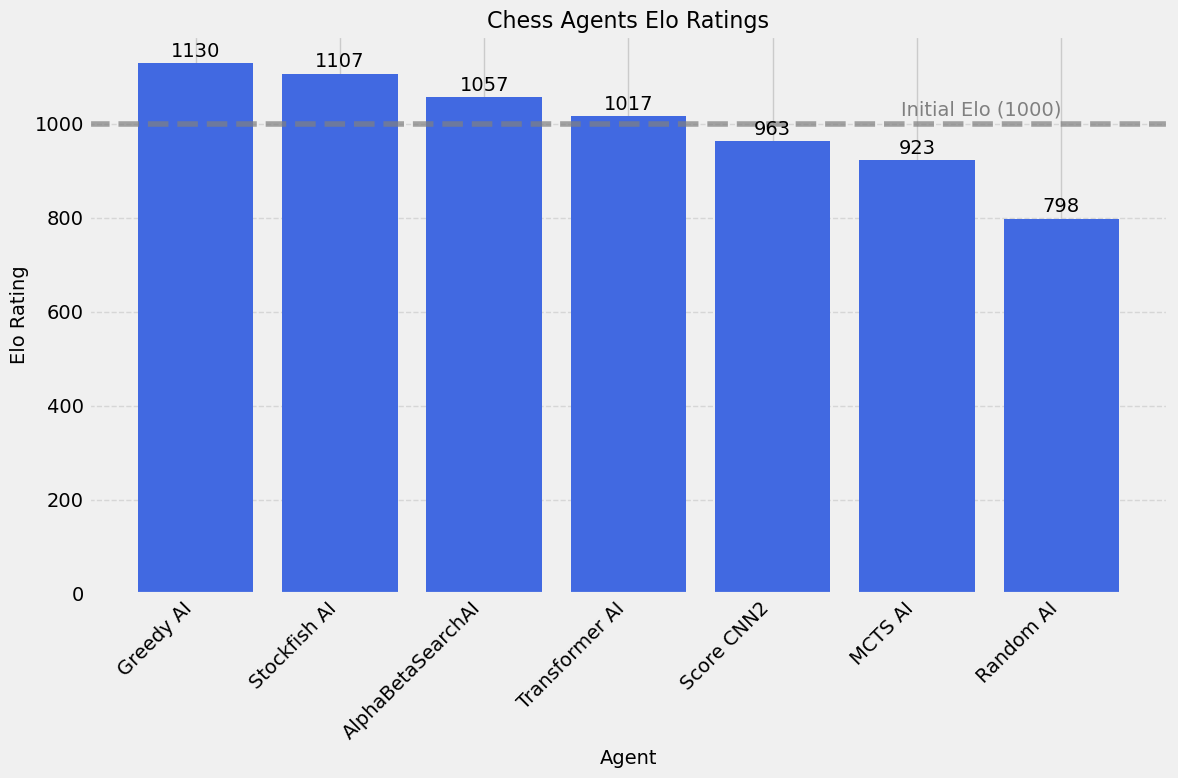

In [19]:
# After calculating Elo ratings using calculate_elo_ratings function

# Create a simple bar chart of Elo ratings
plt.figure(figsize=(12, 8))

# Sort agents by Elo rating for better visualization
sorted_agents = sorted(elo_ratings.items(), key=lambda x: x[1], reverse=True)
agents = [agent for agent, _ in sorted_agents]
ratings = [rating for _, rating in sorted_agents]

# Create the bar chart
bars = plt.bar(agents, ratings, color='royalblue')

# Add value labels on top of each bar
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height + 5,
             f'{int(height)}', ha='center', va='bottom')

# Customize the plot
plt.axhline(y=1000, color='gray', linestyle='--', alpha=0.7)
plt.text(6, 1010, 'Initial Elo (1000)', ha='right', va='bottom', color='gray')

plt.title('Chess Agents Elo Ratings', fontsize=16)
plt.xlabel('Agent', fontsize=14)
plt.ylabel('Elo Rating', fontsize=14)
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.show()

## 7. Head-to-Head Analysis

,Matchup,Total Games,Random AI Wins,Greedy AI Wins,Draws,Random AI Win %,Greedy AI Win %,Draw %,Transformer AI Wins,Transformer AI Win %,MCTS AI Wins,MCTS AI Win %,Stockfish AI Wins,Stockfish AI Win %,AlphaBetaSearchAI Wins,AlphaBetaSearchAI Win %,Score CNN2 Wins,Score CNN2 Win %
0,Random AI vs Greedy AI,19,0.0,19.0,0,0.000000,100.0,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Random AI vs Transformer AI,11,0.0,NaN,6,0.000000,NaN,54.545455,5.0,45.454545,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,Random AI vs MCTS AI,2,1.0,NaN,0,50.000000,NaN,0.000000,NaN,NaN,1.0,50.0,NaN,NaN,NaN,NaN,NaN,NaN
3,Random AI vs Stockfish AI,2,0.0,NaN,0,0.000000,NaN,0.000000,NaN,NaN,NaN,NaN,2.0,100.0,NaN,NaN,NaN,NaN
4,Random AI vs AlphaBetaSearchAI,7,0.0,NaN,0,0.000000,NaN,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,7.0,100.0,NaN,NaN
5,Random AI vs Score CNN2,7,3.0,NaN,0,42.857143,NaN,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.0,57.142857
6,Greedy AI vs Transformer AI,2,NaN,1.0,0,NaN,50.0,0.000000,1.0,50.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,Greedy AI vs MCTS AI,2,NaN,2.0,0,NaN,100.0,0.000000,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN
8,Greedy AI vs Stockfish AI,2,NaN,0.0,0,NaN,0.0,0.000000,NaN,NaN,NaN,NaN,2.0,100.0,NaN,NaN,NaN,NaN
9,Transformer AI vs MCTS AI,2,NaN,NaN,0,NaN,NaN,0.000000,2.0,100.000000,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN


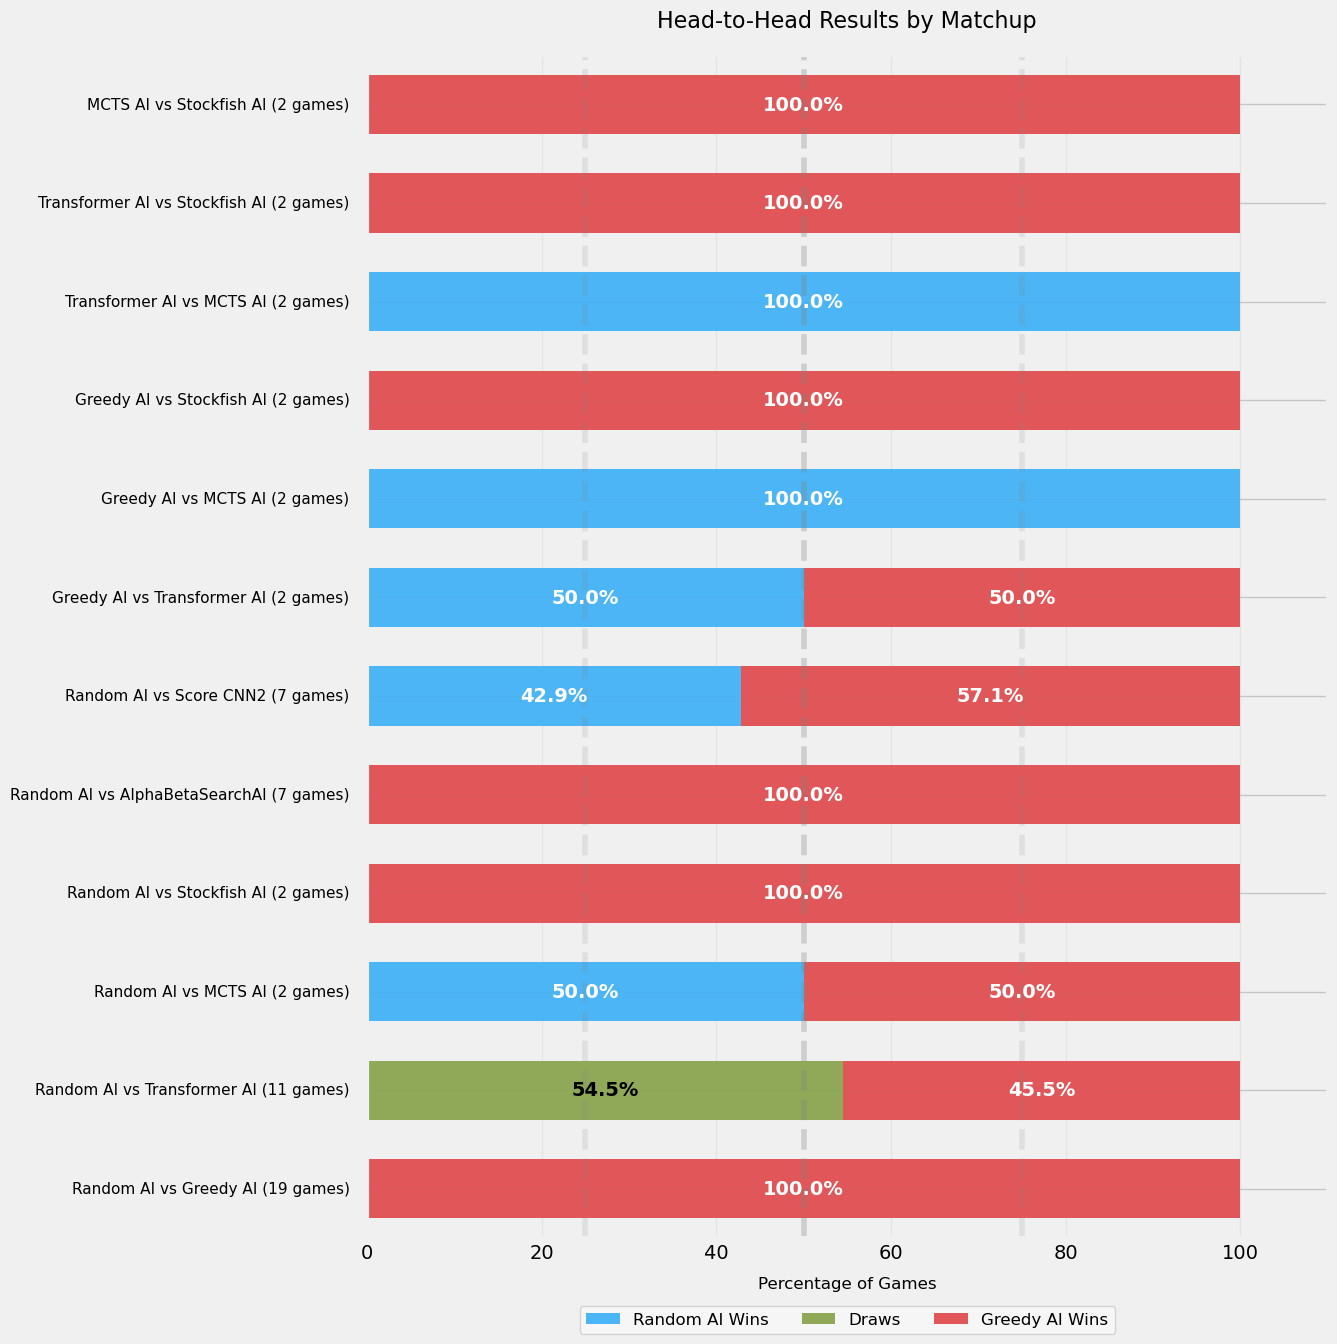

In [11]:
# Create improved head-to-head comparison visualizations with better spacing
try:
    # Map each game to generate head-to-head data
    h2h_data = []
    
    # Get list of unique agents
    unique_agents = df['agent'].unique()
    
    # Group games by game_id to get pairs of players
    for game_id in df['game_id'].unique():
        game_df = df[df['game_id'] == game_id]
        
        if len(game_df) == 2:  # Make sure we have both players
            white_player = game_df[game_df['color'] == 'white']['agent'].values[0]
            black_player = game_df[game_df['color'] == 'black']['agent'].values[0]
            winner_color = game_df['winner'].values[0]  # Get the winner color
            
            # Determine winner
            if winner_color == 'white':
                winner = white_player
                loser = black_player
                result = 'win'
            elif winner_color == 'black':
                winner = black_player
                loser = white_player
                result = 'win'
            elif winner_color == 'draw':
                winner = white_player  # Doesn't matter which one
                loser = black_player
                result = 'draw'
            else:
                continue
            
            h2h_data.append({
                'agent1': white_player,
                'agent2': black_player,
                'winner': winner,
                'loser': loser,
                'result': result
            })
    
    h2h_df = pd.DataFrame(h2h_data)
    
    if len(h2h_df) > 0:
        # Create a summary DataFrame for matchups
        matchup_results = []
        
        # Process each unique pair of agents
        for i, agent1 in enumerate(unique_agents):
            for j, agent2 in enumerate(unique_agents):
                if i >= j:  # Skip self-play and avoid duplicates
                    continue
                
                # Filter games between these two agents
                games = h2h_df[(h2h_df['agent1'] == agent1) & (h2h_df['agent2'] == agent2) | 
                              (h2h_df['agent1'] == agent2) & (h2h_df['agent2'] == agent1)]
                
                if len(games) == 0:
                    continue
                
                agent1_wins = sum((games['winner'] == agent1) & (games['result'] == 'win'))
                agent2_wins = sum((games['winner'] == agent2) & (games['result'] == 'win'))
                draws = sum(games['result'] == 'draw')
                total = len(games)
                
                matchup_results.append({
                    'Matchup': f"{agent1} vs {agent2}",
                    'Total Games': total,
                    f"{agent1} Wins": agent1_wins,
                    f"{agent2} Wins": agent2_wins,
                    'Draws': draws,
                    f"{agent1} Win %": agent1_wins / total * 100,
                    f"{agent2} Win %": agent2_wins / total * 100,
                    'Draw %': draws / total * 100
                })
        
        matchup_df = pd.DataFrame(matchup_results)
        
        # Display the matchup table
        if len(matchup_df) > 0:
            display(matchup_df)
            
            # Create a better visualization - horizontal stacked bar chart with improved spacing
            bar_height = 0.6  # Height of each bar
            spacing = 1.0     # Space between bars
            
            # Calculate figure height based on number of matchups
            num_matchups = len(matchup_df)
            fig_height = max(6, num_matchups * spacing + 2)  # At least 6 inches tall
            
            plt.figure(figsize=(14, fig_height))
            
            # Create custom y positions with better spacing
            y_positions = np.arange(num_matchups) * spacing
            
            for i, row in matchup_df.iterrows():
                matchup = row['Matchup']
                agents = matchup.split(" vs ")
                agent1, agent2 = agents[0], agents[1]
                
                # Create data
                categories = [f"{agent1} Wins", 'Draws', f"{agent2} Wins"]
                values = [row[f"{agent1} Win %"], row['Draw %'], row[f"{agent2} Win %"]]
                colors = ['#4CB5F5', '#90A959', '#E15759']
                
                # Plot with better spacing
                plt.barh(y_positions[i], values[0], height=bar_height, color=colors[0], 
                        label=categories[0] if i == 0 else "")
                plt.barh(y_positions[i], values[1], height=bar_height, left=values[0], 
                        color=colors[1], label=categories[1] if i == 0 else "")
                plt.barh(y_positions[i], values[2], height=bar_height, left=values[0]+values[1], 
                        color=colors[2], label=categories[2] if i == 0 else "")
                
                # Add text labels inside bars (only if enough space)
                min_width_for_label = 10  # Minimum percentage width to show label
                
                if values[0] >= min_width_for_label:
                    plt.text(values[0]/2, y_positions[i], f"{values[0]:.1f}%", 
                            ha='center', va='center', color='white', fontweight='bold')
                
                if values[1] >= min_width_for_label:
                    plt.text(values[0] + values[1]/2, y_positions[i], f"{values[1]:.1f}%", 
                            ha='center', va='center', color='black', fontweight='bold')
                
                if values[2] >= min_width_for_label:
                    plt.text(values[0] + values[1] + values[2]/2, y_positions[i], f"{values[2]:.1f}%", 
                            ha='center', va='center', color='white', fontweight='bold')
                
                # Add game count after matchup label, not as separate text
                plt.text(-2, y_positions[i], f"{matchup} ({row['Total Games']} games)", 
                        ha='right', va='center', fontsize=11)
            
            # Set y-ticks to empty to prevent duplicate labels
            plt.yticks(y_positions, [""] * num_matchups)
            
            # Add a thin line for each matchup to align with bars
            for pos in y_positions:
                plt.axhline(y=pos, color='gray', linestyle='-', alpha=0.1, linewidth=0.5)
            
            # Set appropriate limits
            plt.xlim(0, 110)  # Give extra space for 100% plus some padding
            plt.ylim(-0.5, max(y_positions) + 0.5)  # Add padding above and below
            
            # Add labels and title
            plt.xlabel('Percentage of Games', fontsize=12, labelpad=10)
            plt.title('Head-to-Head Results by Matchup', fontsize=16, pad=20)
            
            # Create a more prominent legend
            legend = plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.05), 
                               ncol=3, frameon=True, fontsize=12)
            legend.get_frame().set_facecolor('#f8f8f8')
            legend.get_frame().set_linewidth(1)
            
            # Add percentage markers on x-axis
            plt.axvline(x=50, color='gray', linestyle='--', alpha=0.3)
            plt.axvline(x=25, color='gray', linestyle='--', alpha=0.15)
            plt.axvline(x=75, color='gray', linestyle='--', alpha=0.15)
            
            # Add a stronger grid on x-axis
            plt.grid(axis='x', alpha=0.3)
            
            plt.tight_layout(pad=2.0)  # Add padding around the figure
            plt.show()
    else:
        print("No head-to-head data available.")
except Exception as e:
    print(f"Error in head-to-head analysis: {e}")
    import traceback
    traceback.print_exc()

## 8. Summary and Conclusions

C:\Users\luisw\AppData\Local\Temp\ipykernel_28556\3616145762.py:5: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  ('Blunder Rate', df.groupby('agent').apply(lambda x: x['blunder'].sum() / x['moves_count'].sum() * 100 if x['moves_count'].sum() > 0 else 0)),
C:\Users\luisw\AppData\Local\Temp\ipykernel_28556\3616145762.py:6: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  ('Mistake Rate', df.groupby('agent').appl

,Blunder Rate,Mistake Rate,Decisive Move %,Good-to-Bad Ratio,Win %,Elo Rating
agent,,,,,,
AlphaBetaSearchAI,19.718310,16.197183,16.724387,0.868421,100.000000,1057
Greedy AI,25.302663,19.612591,19.679175,0.532468,85.185185,1130
MCTS AI,42.023346,17.509728,34.062826,0.311224,20.000000,923
Random AI,44.340551,17.125984,34.167782,0.293444,21.052632,798
Score CNN2,65.030675,14.723926,56.681319,0.116438,57.142857,963
Stockfish AI,6.547619,4.761905,8.370049,2.818182,100.000000,1107
Transformer AI,32.971506,10.312076,29.349475,0.758950,47.368421,1017


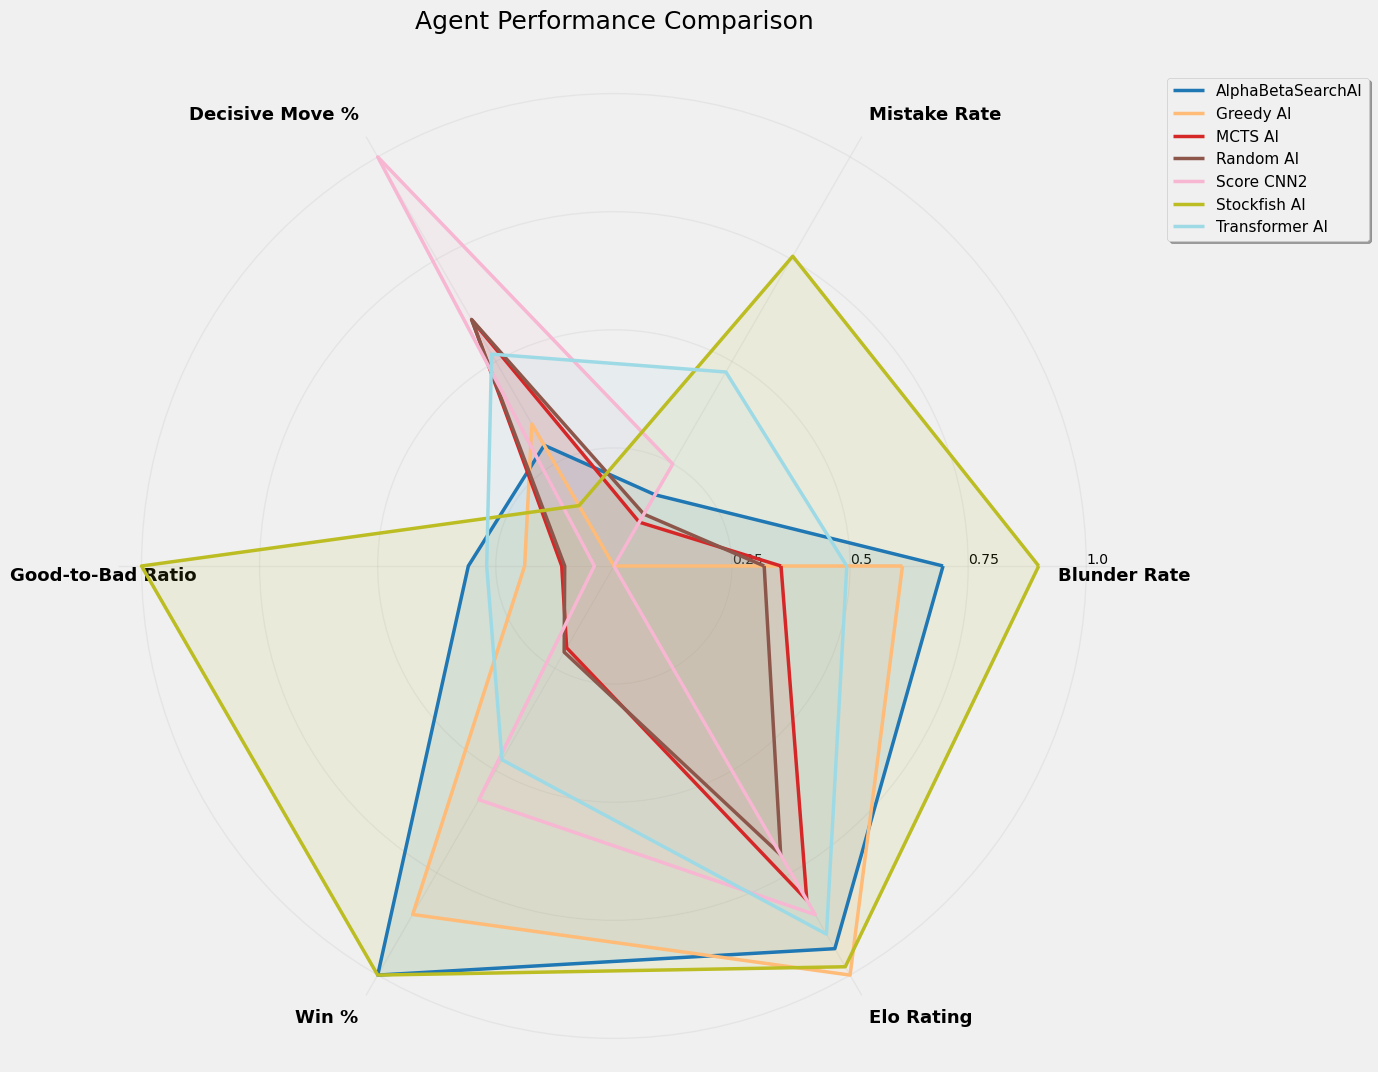


Metric Definitions:
- Blunder Rate: Percentage of moves that are blunders (lower is better)
- Mistake Rate: Percentage of moves that are mistakes (lower is better)
- Decisive Move %: Percentage of moves that decisively change the position (higher is better)
- Good-to-Bad Ratio: Ratio of good moves (brilliant+excellent+good) to bad moves (inaccuracies+mistakes+blunders)
- Win %: Percentage of games won
- Elo Rating: Calculated Elo rating based on game results

Conclusions:
1. Agents with higher Elo ratings demonstrate stronger overall play.
2. The Good-to-Bad Ratio reveals how consistently an agent makes quality moves.
3. Decisive Move % indicates an agent's ability to find critical, game-changing moves.
4. Agents with high win rates but lower Decisive Move % may be more positionally solid.

Recommendations:
- Focus improvement efforts on agents with high blunder and mistake rates
- Consider phase-specific training (opening/middlegame/endgame) based on performance gaps
- Agents with hi

In [12]:
# Create an overall performance ranking with updated Elo ratings
try:
    # Create a composite score based on multiple metrics
    performance_metrics = [
        ('Blunder Rate', df.groupby('agent').apply(lambda x: x['blunder'].sum() / x['moves_count'].sum() * 100 if x['moves_count'].sum() > 0 else 0)),
        ('Mistake Rate', df.groupby('agent').apply(lambda x: x['mistake'].sum() / x['moves_count'].sum() * 100 if x['moves_count'].sum() > 0 else 0)),
        ('Decisive Move %', df.groupby('agent')['decisive_move_percentage'].mean()),
        ('Good-to-Bad Ratio', df.groupby('agent').apply(lambda x: 
                                               (x['brilliant'].sum() + x['excellent'].sum() + x['good'].sum()) / 
                                               (x['inaccuracy'].sum() + x['mistake'].sum() + x['blunder'].sum())
                                               if (x['inaccuracy'].sum() + x['mistake'].sum() + x['blunder'].sum()) > 0 
                                               else 0))
    ]
    
    # Create summary DataFrame
    summary_df = pd.DataFrame({name: values for name, values in performance_metrics})
    
    # Add win percentages
    win_rates = df.groupby('agent').apply(lambda x: x['is_winner'].sum() / len(x) * 100)
    summary_df['Win %'] = win_rates
    
    # Add the new Elo ratings
    # Convert dictionary to Series for easy joining
    elo_series = pd.Series(elo_ratings)
    summary_df['Elo Rating'] = elo_series
    
    # Display summary
    display(summary_df)
    
    # Create an improved radar chart with better visibility
    from math import pi
    
    # Prepare data for radar chart
    # Normalize all metrics to 0-1 scale (1 is best)
    radar_df = summary_df.copy()
    
    # Normalize metrics where lower is better (invert them)
    for col in ['Blunder Rate', 'Mistake Rate']:
        if col in radar_df.columns:
            max_val = radar_df[col].max()
            if max_val > 0:
                radar_df[col] = 1 - (radar_df[col] / max_val)
    
    # Normalize metrics where higher is better
    for col in ['Win %', 'Elo Rating', 'Decisive Move %', 'Good-to-Bad Ratio']:
        if col in radar_df.columns:
            max_val = radar_df[col].max()
            if max_val > 0:
                radar_df[col] = radar_df[col] / max_val
    
    # Improved radar chart plotting
    categories = radar_df.columns.tolist()
    N = len(categories)

    # Create angles for each metric
    angles = [n / N * 2 * pi for n in range(N)]
    angles += angles[:1]  # Close the loop

    # Create figure with more space and adjusted layout
    fig = plt.figure(figsize=(16, 14))
    plt.subplots_adjust(right=0.7)  # Make room for the legend
    ax = fig.add_subplot(111, polar=True)

    # Fix the white line issue by setting frame visibility off
    ax.spines['polar'].set_visible(False)

    # Add background grid with better styling
    ax.grid(True, linestyle='-', alpha=0.3)

    # Use the original color palette that you preferred
    colors = plt.cm.tab20(np.linspace(0, 1, len(radar_df.index)))

    # Draw each agent
    for i, agent in enumerate(radar_df.index):
        values = radar_df.loc[agent].values.tolist()
        values += values[:1]  # Close the loop
        
        # Plot values with distinct colors and thicker lines
        ax.plot(angles, values, linewidth=2.5, label=agent, color=colors[i])
        ax.fill(angles, values, alpha=0.1, color=colors[i])

    # Improve category labels
    ax.set_xticks(angles[:-1])
    ax.set_xticklabels(categories, size=13, fontweight='bold')

    # Position the tick labels better to prevent occlusion - fixed approach
    # Adjust the position of the labels based on their angle
    for i, label in enumerate(ax.get_xticklabels()):
        angle = angles[i]
        # Different positioning based on the quadrant
        if angle == 0:
            label.set_horizontalalignment('center')
            label.set_verticalalignment('top')
        elif 0 < angle < pi/2:
            label.set_horizontalalignment('left')
            label.set_verticalalignment('bottom')
        elif angle == pi/2:
            label.set_horizontalalignment('center')
            label.set_verticalalignment('bottom')
        elif pi/2 < angle < pi:
            label.set_horizontalalignment('right')
            label.set_verticalalignment('bottom')
        elif angle == pi:
            label.set_horizontalalignment('center')
            label.set_verticalalignment('top')
        elif pi < angle < 3*pi/2:
            label.set_horizontalalignment('right')
            label.set_verticalalignment('top')
        elif angle == 3*pi/2:
            label.set_horizontalalignment('center')
            label.set_verticalalignment('top')
        else:
            label.set_horizontalalignment('left')
            label.set_verticalalignment('top')
        
        # We're NOT changing the position of the labels with label.set_position()
        # This ensures they stay at the end of each axis

    # Add radial labels for scale reference
    ax.set_rlabel_position(0)
    ax.set_rticks([0.25, 0.5, 0.75, 1])
    ax.set_yticklabels(["0.25", "0.5", "0.75", "1.0"], size=10)

    # Extend the y-limit slightly to make room for the outer labels
    ax.set_ylim(0, 1.05)

    # Add legend with fixed positioning outside the plot
    legend = plt.legend(
        loc='upper left',
        bbox_to_anchor=(1.05, 1.0),
        fontsize=11,
        frameon=True,
        fancybox=True,
        shadow=True,
        ncol=1  # One column for clarity
    )

    plt.title('Agent Performance Comparison', size=18, pad=30)

    plt.show()


    
    print("\nMetric Definitions:")
    print("===================")
    print("- Blunder Rate: Percentage of moves that are blunders (lower is better)")
    print("- Mistake Rate: Percentage of moves that are mistakes (lower is better)")
    print("- Decisive Move %: Percentage of moves that decisively change the position (higher is better)")
    print("- Good-to-Bad Ratio: Ratio of good moves (brilliant+excellent+good) to bad moves (inaccuracies+mistakes+blunders)")
    print("- Win %: Percentage of games won")
    print("- Elo Rating: Calculated Elo rating based on game results")
    
    print("\nConclusions:")
    print("=============")
    print("1. Agents with higher Elo ratings demonstrate stronger overall play.")
    print("2. The Good-to-Bad Ratio reveals how consistently an agent makes quality moves.")
    print("3. Decisive Move % indicates an agent's ability to find critical, game-changing moves.")
    print("4. Agents with high win rates but lower Decisive Move % may be more positionally solid.")
    print("\nRecommendations:")
    print("================")
    print("- Focus improvement efforts on agents with high blunder and mistake rates")
    print("- Consider phase-specific training (opening/middlegame/endgame) based on performance gaps")
    print("- Agents with higher Elo ratings should be used as baselines for future improvements")
    
except Exception as e:
    print(f"Error in summary and conclusions: {e}")